In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
import numpy
import string
import re
import gensim.downloader

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

import spacy
import en_core_web_lg

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
df = pd.read_csv('../../data/insurance_qna_dataset.csv',delimiter="\t")
df.head()
df.drop('Unnamed: 0',axis = 1)

,Question,Answer
0,What Happens When Term Life Insurance Is Paid ...,Actually term life insurance cannot be paid up...
1,What Happens When Term Life Insurance Is Paid ...,Term life insurance is never paid up. Assuming...
2,What Happens When Term Life Insurance Is Paid ...,Term Life Insurance does not have the option t...
3,What Does Renters Insurance Cover?,A renters insurance policy will typically prov...
4,What Does Renters Insurance Cover?,If you apartment was on fire and all your pers...
...,...,...
27989,What is,I'm not sure.\n
27990,Can I,I'm not sure.\n
27991,Which,I'm not sure.\n
27992,Does,I'm not sure.\n


In [3]:
df_test = pd.read_excel('../../data/testData.xlsx')
trueQuestions = df['Question'][df_test['ID']].reset_index()
trueQuestions = trueQuestions['Question']
df_test.head()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [4]:
df.drop_duplicates('Question', inplace = True, ignore_index = True)

## Task 13: Pretrained word vectors combined with sum and average vector arithmetics

In [5]:
#news_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [6]:
#glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

#glove_vectors.save('wiki300.vectors')

from gensim.models import KeyedVectors

glove_vectors = KeyedVectors.load('wiki300.vectors')

In [7]:
def getVectors(dataFrame):
    sentances = []
    for question in dataFrame:
        newVector = np.zeros(300, dtype= float)
        for word in question.split(" "):
            word = word.lower()
            try:
                vector = glove_vectors[word]
                newVector += vector
            except:
                continue
        sentances.append(newVector)
    return sentances

In [8]:
def findBestDistanceMetric(x,y,yTrue, nBest = 100):
    performance = []
    corpus = x
    X = getVectors(corpus)
    testCorpus = y
    Y = getVectors(testCorpus)
    for distanceMetric in ('euclidean_distances','manhattan_distances','cosine_distances'):
        score = 0
        distance = eval(distanceMetric + '(Y,X)')
        for i in range(0, len(yTrue)):
            nInd = distance[i,:].argsort()[:nBest]
            nQue = corpus[nInd]
            realQ = yTrue[i]
            temp = 2 * nBest
            for k in range(0, nBest):
                if realQ == nQue[nInd[k]]:
                    temp = k
                    break
            score = score + temp
        print(distanceMetric + ': ' + str(score))
        performance.append(score)
    objects = ('euclidean_distances','manhattan_distances','cosine_distances')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Error')
    plt.title('Error for different metrics')
    plt.show()     

euclidean_distances: 3296
manhattan_distances: 3179
cosine_distances: 2654


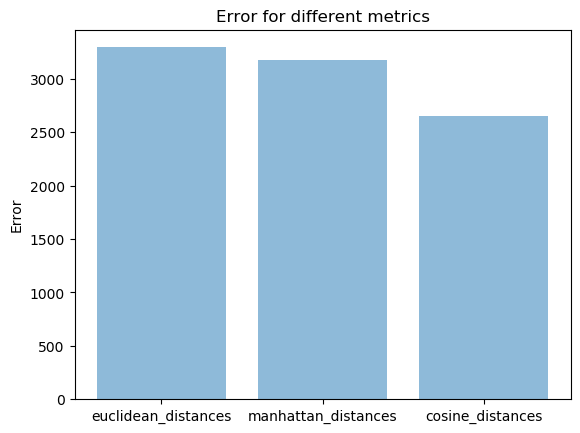

In [9]:
findBestDistanceMetric(df['Question'], df_test['Q\''], trueQuestions)

##  Task 14: Pretrained word vectors combined with IDF weighted average and sum vector arithmetics

In [10]:
def getVectorsIDF(dataFrame):
    vectorizer = TfidfVectorizer()
    vectorizer.fit_transform(dataFrame)
    dictionary = {k: v for k, v in zip(vectorizer.get_feature_names(), vectorizer.idf_)}
    sentances = []
    for question in dataFrame:
        newVector = np.zeros(300, dtype= float)
        for word in question.split(" "):
            word = word.lower()
            try:
                vector = glove_vectors[word]
                coef = dictionary[word]
                result = vector * coef
                newVector += result
            except:
                continue
        sentances.append(newVector)
    return sentances

In [11]:
def findBestDistanceMetricIDF(x,y,yTrue, nBest = 100):
    performance = []
    corpus = x
    X = getVectorsIDF(corpus)
    testCorpus = y
    Y = getVectorsIDF(testCorpus)
    for distanceMetric in ('euclidean_distances','manhattan_distances','cosine_distances'):
        score = 0
        distance = eval(distanceMetric + '(Y,X)')
        for i in range(0, len(yTrue)):
            nInd = distance[i,:].argsort()[:nBest]
            nQue = corpus[nInd]
            realQ = yTrue[i]
            temp = 2 * nBest
            for k in range(0, nBest):
                if realQ == nQue[nInd[k]]:
                    temp = k
                    break
            score = score + temp
        print(distanceMetric + ': ' + str(score))
        performance.append(score)
    objects = ('euclidean_distances','manhattan_distances','cosine_distances')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Error')
    plt.title('Error for different metrics')
    plt.show()    

euclidean_distances: 5736
manhattan_distances: 5144
cosine_distances: 3243


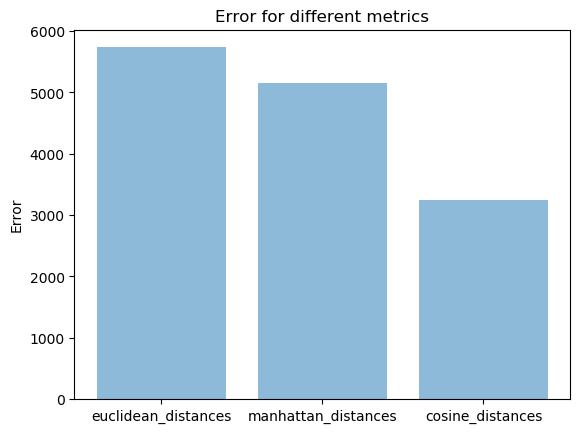

In [12]:
findBestDistanceMetricIDF(df['Question'], df_test['Q\''], trueQuestions)

## Task 15: Pretrained word vectors combined with POS+NER weighted average and sum vector arithmetics

In [13]:
nlp = en_core_web_lg.load()

In [14]:
test = nlp("I want to ride a bike")
for token in test:
    print(token.text)
    print(token.pos_)

I
PRON
want
VERB
to
PART
ride
VERB
a
DET
bike
NOUN


In [15]:
def getVectorsPOS(dataFrame):
    sentances = []
    coef = 1
    for question in dataFrame:
        newVector = np.zeros(300, dtype= float)
        for word in nlp(question):
            try:              
                vector = glove_vectors[word.text.lower()]
                if token.pos_ == 'VERB' or token.pos_ == 'PROPN':
                    coef = 1.5
                elif token.pos_ == 'ADV' or token.pos_ == "ADJ":
                    coef = 1.2
                elif token.pos_ == 'ADP' or token.pos_ == "AUX" or token.pos_ == 'CONJ' or token.pos_ == "DET" or token.pos_ == 'INTJ': 
                    coef = 0.7
                else:
                    coef = 1
                result = vector * coef
                newVector += result
            except:
                continue
        sentances.append(newVector)
    return sentances

In [16]:
def findBestDistanceMetricPOS(x,y,yTrue, nBest = 100):
    performance = []
    corpus = x
    X = getVectorsPOS(corpus)
    testCorpus = y
    Y = getVectorsPOS(testCorpus)
    for distanceMetric in ('euclidean_distances','manhattan_distances','cosine_distances'):
        score = 0
        distance = eval(distanceMetric + '(Y,X)')
        for i in range(0, len(yTrue)):
            nInd = distance[i,:].argsort()[:nBest]
            nQue = corpus[nInd]
            realQ = yTrue[i]
            temp = 2 * nBest
            for k in range(0, nBest):
                if realQ == nQue[nInd[k]]:
                    temp = k
                    break
            score = score + temp
        print(distanceMetric + ': ' + str(score))
        performance.append(score)
    objects = ('euclidean_distances','manhattan_distances','cosine_distances')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Error')
    plt.title('Error for different metrics')
    plt.show()    

euclidean_distances: 1956
manhattan_distances: 1813
cosine_distances: 1624


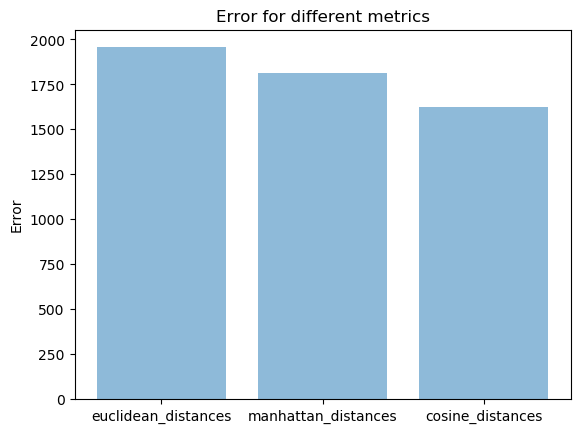

In [17]:
findBestDistanceMetricPOS(df['Question'], df_test['Q\''], trueQuestions)